In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.lines as mlines

In [2]:
airport=pd.read_csv("C:\\Users\\raghu\\Desktop\\flight-delays\\airports.csv")

In [3]:
airport.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [4]:
train=pd.read_csv("train_new.csv")

In [16]:
train.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,...,WHEELS_OFF_hour,WHEELS_OFF_mins,WHEELS_ON_hour,WHEELS_ON_mins,SCHEDULED_DEPARTURE_Abstime,DEPARTURE_TIME_Abstime,SCHEDULED_ARRIVAL_Abstime,ARRIVAL_TIME_Abstime,WHEELS_OFF_Abstime,WHEELS_ON_Abstime
0,1,1,4,AS,ANC,SEA,-11.0,21.0,205.0,194.0,...,0.0,15.0,4.0,4.0,5,1434.0,270,248.0,15.0,244.0
1,1,1,4,AA,LAX,PBI,-8.0,12.0,280.0,279.0,...,0.0,14.0,7.0,37.0,10,2.0,470,461.0,14.0,457.0
2,1,1,4,US,SFO,CLT,-2.0,16.0,286.0,293.0,...,0.0,34.0,8.0,0.0,20,18.0,486,491.0,34.0,480.0
3,1,1,4,AA,LAX,MIA,-5.0,15.0,285.0,281.0,...,0.0,30.0,7.0,48.0,20,15.0,485,476.0,30.0,468.0
4,1,1,4,AS,SEA,ANC,-1.0,11.0,235.0,215.0,...,0.0,35.0,2.0,54.0,25,24.0,200,179.0,35.0,174.0


In [93]:
number_of_flights=train[['ORIGIN_AIRPORT','DESTINATION_AIRPORT']]
number_of_flights=number_of_flights.groupby(['ORIGIN_AIRPORT','DESTINATION_AIRPORT'],as_index=False).size().reset_index()
number_of_flights=number_of_flights[number_of_flights['ORIGIN_AIRPORT'].apply(lambda x: len(list(x))<4)]
number_of_flights=number_of_flights[number_of_flights['DESTINATION_AIRPORT'].apply(lambda x: len(list(x))<4)]

In [94]:
number_of_flights.head()

,ORIGIN_AIRPORT,DESTINATION_AIRPORT,0
2489,ABE,ATL,898
2490,ABE,DTW,711
2491,ABE,ORD,665
2492,ABI,DFW,2329
2493,ABQ,ATL,801


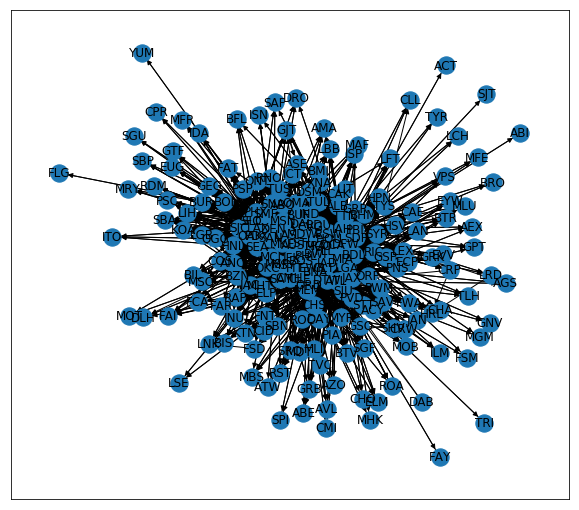

In [209]:
graph=nx.from_pandas_edgelist(number_of_flights,source ='ORIGIN_AIRPORT',edge_attr=0,target = 'DESTINATION_AIRPORT',create_using = nx.DiGraph())
plt.figure(figsize = (10,9))
nx.draw_networkx(graph)
plt.show()

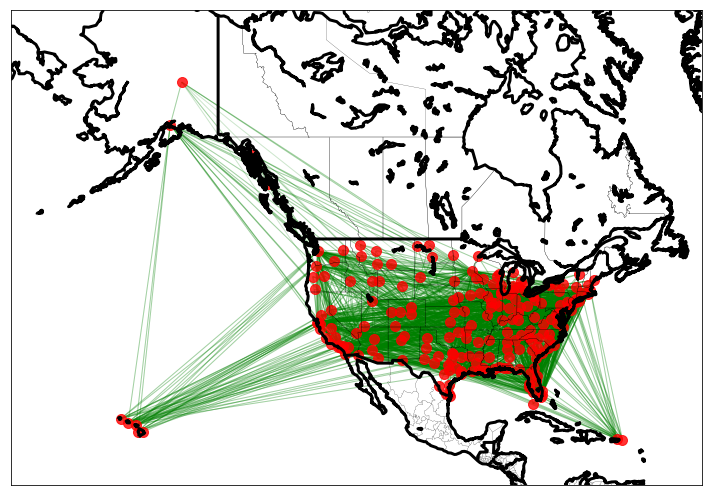

In [109]:
plt.figure(figsize = (10,9))
m = Basemap(projection='merc',llcrnrlon=-180,llcrnrlat=10,urcrnrlon=-50,
urcrnrlat=70, lat_ts=0, resolution='l',suppress_ticks=True)
mx, my = m(airport['LONGITUDE'].values, airport['LATITUDE'].values)
pos = {}
for count, elem in enumerate (airport['IATA_CODE']):
     pos[elem] = (mx[count], my[count])

nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(),node_color = 'r', alpha = 0.8, node_size = 100)
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='g', alpha=0.2, arrows = False)
m.drawcountries(linewidth = 3)

m.drawstates(linewidth = 0.2)

m.drawcoastlines(linewidth=3)

plt.tight_layout()

# plt.savefig("./images/map_1.png", format = "png", dpi = 300)

plt.show()

In [181]:
delay_flight=train[['ORIGIN_AIRPORT','DESTINATION_AIRPORT','ARRIVAL_DELAY']]
delay_flight['Travel_time']=train['ARRIVAL_TIME_Abstime']-train['DEPARTURE_TIME_Abstime']
delay_flight['Travel_time']=abs(delay_flight['Travel_time'])
delay_flight['ARRIVAL_DELAY']=abs(delay_flight['ARRIVAL_DELAY'])
airport_new=airport[['IATA_CODE','LATITUDE','LONGITUDE']]
delay_flight=delay_flight.merge(airport_new,left_on='ORIGIN_AIRPORT',right_on='IATA_CODE')
delay_flight=delay_flight.merge(airport_new,left_on='DESTINATION_AIRPORT',right_on='IATA_CODE')
delay_flight['Distance']=np.sqrt(abs(np.square(delay_flight['LATITUDE_x']-delay_flight['LATITUDE_y'])-np.square(delay_flight['LONGITUDE_x']-delay_flight['LONGITUDE_y'])))
delay_flight['Speed']=delay_flight['Distance']/delay_flight['Travel_time']
delay_flight['Travel_time_actual']=delay_flight['Travel_time']+delay_flight['ARRIVAL_DELAY']
delay_flight['Distance_actual']=delay_flight['Speed']*delay_flight['Travel_time_actual']
delay_flight['tan_theta']=(delay_flight['LONGITUDE_y']-delay_flight['LONGITUDE_x'])/(delay_flight['LATITUDE_y']-delay_flight['LATITUDE_x'])
delay_flight['Theta']=np.arctan(delay_flight['tan_theta'])
delay_flight['LATITUDE_new']=delay_flight['Distance_actual']*np.cos(delay_flight['Theta'])+delay_flight['LATITUDE_x']
delay_flight['LONGITUDE_new']=delay_flight['Distance_actual']*np.sin(delay_flight['Theta'])+delay_flight['LONGITUDE_x']
delay_flight.drop(['IATA_CODE_x','IATA_CODE_y'],axis=1,inplace=True)

C:\Users\raghu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\raghu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raghu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [182]:
airport.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [183]:
delay_flight.head()

,ORIGIN_AIRPORT,DESTINATION_AIRPORT,ARRIVAL_DELAY,Travel_time,LATITUDE_x,LONGITUDE_x,LATITUDE_y,LONGITUDE_y,Distance,Speed,Travel_time_actual,Distance_actual,tan_theta,Theta,LATITUDE_new,LONGITUDE_new
0,ANC,SEA,22.0,1186.0,61.17432,-149.99619,47.44898,-122.30931,24.04534,0.020274,1208.0,24.491375,-2.017209,-1.110567,72.052252,-171.939253
1,ANC,SEA,14.0,254.0,61.17432,-149.99619,47.44898,-122.30931,24.04534,0.094667,268.0,25.370673,-2.017209,-1.110567,72.442796,-172.727062
2,ANC,SEA,24.0,260.0,61.17432,-149.99619,47.44898,-122.30931,24.04534,0.092482,284.0,26.264910,-2.017209,-1.110567,72.839974,-173.528253
3,ANC,SEA,8.0,60.0,61.17432,-149.99619,47.44898,-122.30931,24.04534,0.400756,68.0,27.251385,-2.017209,-1.110567,73.278121,-174.412086
4,ANC,SEA,35.0,258.0,61.17432,-149.99619,47.44898,-122.30931,24.04534,0.093199,293.0,27.307304,-2.017209,-1.110567,73.302958,-174.462187


In [205]:
unique_flights=delay_flight[delay_flight.duplicated(subset=['ORIGIN_AIRPORT'])==False]
unique_flights=unique_flights[unique_flights.duplicated(subset=['DESTINATION_AIRPORT'])==False]
original=unique_flights[['ORIGIN_AIRPORT','DESTINATION_AIRPORT','LATITUDE_x','LONGITUDE_x','LATITUDE_y','LONGITUDE_y']]
new=unique_flights[['ORIGIN_AIRPORT','DESTINATION_AIRPORT','LATITUDE_x','LONGITUDE_x','LATITUDE_new','LONGITUDE_new']]
new['DESTINATION_AIRPORT']=new['DESTINATION_AIRPORT'].apply(lambda x: "_".join(x) )

In [262]:
a=original[['ORIGIN_AIRPORT','LATITUDE_x','LONGITUDE_x']].rename(columns={'ORIGIN_AIRPORT':'AIRPORT','LATITUDE_x':'LATITUDE','LONGITUDE_x':'LONGITUDE'})
b=original[['DESTINATION_AIRPORT','LATITUDE_y','LONGITUDE_y']].rename(columns={'DESTINATION_AIRPORT':'AIRPORT','LATITUDE_y':'LATITUDE','LONGITUDE_y':'LONGITUDE'})
c=new[['DESTINATION_AIRPORT','LATITUDE_new','LONGITUDE_new']].rename(columns={'DESTINATION_AIRPORT':'AIRPORT','LATITUDE_new':'LATITUDE','LONGITUDE_new':'LONGITUDE'})
address=pd.concat([a,b,c],axis=0)

In [264]:
address.head()

,AIRPORT,LATITUDE,LONGITUDE
0,ANC,61.17432,-149.99619
119295,SEA,47.44898,-122.30931
231270,BUF,42.94052,-78.73217
333430,SJU,18.43942,-66.00183
531035,VPS,30.48325,-86.52540


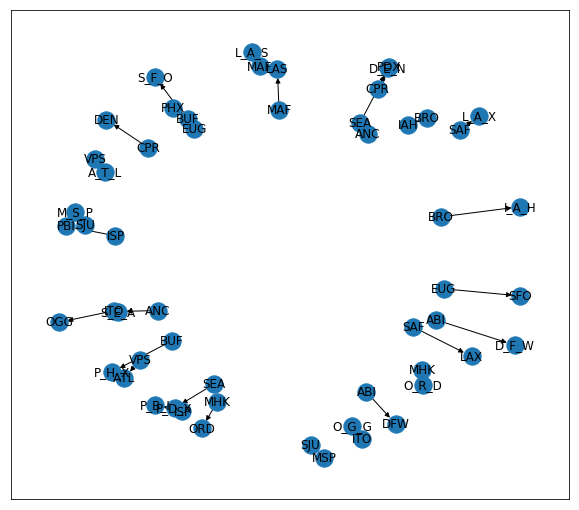

In [267]:
graph2=nx.from_pandas_edgelist(original,source ='ORIGIN_AIRPORT',target = 'DESTINATION_AIRPORT',create_using = nx.DiGraph())
graph3=nx.from_pandas_edgelist(new,source ='ORIGIN_AIRPORT',target = 'DESTINATION_AIRPORT',create_using = nx.DiGraph())
plt.figure(figsize = (10,9))
nx.draw_networkx(graph2)
nx.draw_networkx(graph3)
plt.show()

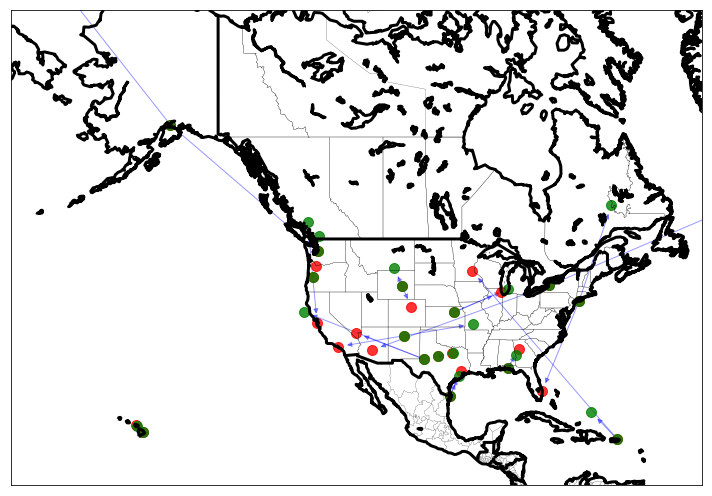

In [278]:
plt.figure(figsize = (10,9))
m = Basemap(projection='merc',llcrnrlon=-180,llcrnrlat=10,urcrnrlon=-50,
urcrnrlat=70, lat_ts=0, resolution='l',suppress_ticks=True)
mx, my = m(address['LONGITUDE'].values, address['LATITUDE'].values)
pos = {}
for count, elem in enumerate (address['AIRPORT']):
     pos[elem] = (mx[count], my[count])

nx.draw_networkx_nodes(G = graph2, pos = pos, node_list = graph2.nodes(),node_color = 'r', alpha = 0.8, node_size = 100)
nx.draw_networkx_edges(G = graph2, pos = pos, edge_color='b', alpha=0.4, arrows = True)
nx.draw_networkx_nodes(G = graph3, pos = pos, node_list = graph3.nodes(),node_color = 'g', alpha = 0.8, node_size = 100)
nx.draw_networkx_edges(G = graph3, pos = pos, edge_color='b', alpha=0.4, arrows = True)
m.drawcountries(linewidth = 3)

m.drawstates(linewidth = 0.2)

m.drawcoastlines(linewidth=3)

plt.tight_layout()

# plt.savefig("./images/map_1.png", format = "png", dpi = 300)

plt.show()